# Lab 02 : Vanilla GAN with MLP - solution

The goal is to implement a GAN architecture with MLPs to generate new MNIST images.</br>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture15/lab02_GAN_MLP'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/GAN/new_codes/labs_lecture15/lab02_GAN_MLP
/content/gdrive/My Drive/GAN/new_codes/labs_lecture15/lab02_GAN_MLP


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

### GPU is required to train GAN

In [3]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [4]:
# Libraries
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

### MNIST dataset 

In [5]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
print(train_data.size())

torch.Size([60000, 28, 28])


### Network architecture

In [6]:
# Global constants
# n : nb of pixels along each spatial dimension
# dz : latent dimension
# d : hidden dimension
# b : batch size
n = train_data.size(1)
dz = n
d = 32* (n//4)**2 # hidden dimension is a function of image size
b = 64


In [7]:
# Define the generator and discriminator networks
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        # COMPLETE HERE
        self.linear1 = nn.Linear(dz, d, bias=True) 
        self.bn1 = nn.BatchNorm1d(d)
        self.linear2 = nn.Linear(d, d, bias=True) 
        self.bn2 = nn.BatchNorm1d(d)
        self.linear3 = nn.Linear(d, n**2, bias=True)
    def forward(self, z): 
        # COMPLETE HERE
        h = self.linear1(z) # [b, d]
        h = self.bn1(h)
        h = torch.relu(h)
        h = self.linear2(h) # [b, d]
        h = self.bn2(h)
        h = torch.relu(h)
        h = self.linear3(h) # [b, n**2]
        h = h.view(-1, 1, n, n) # [b, 1, n, n], nb colors = 1
        #g_z = torch.tanh(h) # in general [-1,1]
        g_z = torch.sigmoid(h) # for mnist [0,1]
        return g_z

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        # COMPLETE HERE
        self.linear1 = nn.Linear(n**2, d, bias=True)
        self.bn1 = nn.BatchNorm1d(d)
        self.linear2 = nn.Linear(d, d, bias=True)
        self.bn2 = nn.BatchNorm1d(d)
        self.linear3 = nn.Linear(d, 1, bias=True)
    def forward(self, h): 
        # COMPLETE HERE
        h = h.view(-1, n**2) # [b, n**2]
        h = self.linear1(h) # [b, d]
        h = self.bn1(h)
        h = torch.relu(h)
        h = self.linear2(h) # [b, d]
        h = self.bn2(h)
        h = torch.relu(h)
        h = self.linear3(h) # [b, 1], nb colors = 1
        d_h = torch.sigmoid(h)
        return d_h

# Instantiate the network
net_g = generator()
net_g = net_g.to(device)
print(net_g)
utils.display_num_param(net_g) 
net_d = discriminator()
net_d = net_d.to(device)
print(net_d)
utils.display_num_param(net_d) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=init_lr)
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=init_lr)

b = 10
idx = torch.LongTensor(b).random_(0,60000)
x_real = train_data[idx,:,:].view(b,-1).to(device) # [b, n**2]
print(x_real.size())

z = torch.rand(b, dz).to(device) # [b, dz]
print(z.size())

p_one = torch.ones(b, 1).to(device)
p_zero = torch.zeros(b, 1).to(device)

# update g
optimizer_g.zero_grad()
x_fake = net_g(z) # [b, 1, n, n]
p_fake = net_d(x_fake) # [b, 1]
print(x_fake.size(), p_fake.size())
loss_fake = nn.BCELoss()(p_fake, p_one)
loss = loss_fake
loss.backward()
optimizer_g.step()

# update d
optimizer_d.zero_grad()
x_fake = net_g(z) # [b, 1, n, n]
p_fake = net_d(x_fake) # [b, 1]
p_real = net_d(x_real.view(-1,n,n).unsqueeze(1)) # [b, 1]
print(x_fake.size(), p_fake.size(), p_real.size())
loss_real = nn.BCELoss()(p_real, p_one)
loss_fake = nn.BCELoss()(p_fake, p_zero)
loss = loss_real + loss_fake
loss.backward()
optimizer_d.step()


generator(
  (linear1): Linear(in_features=28, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=784, bias=True)
)
There are 3742032 (3.74 million) parameters in this neural network
discriminator(
  (linear1): Linear(in_features=784, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=1, bias=True)
)
There are 3698913 (3.70 million) parameters in this neural network
torch.Size([10, 784])
torch.Size([10, 28])
torch.Size([10, 1, 28, 28]) 

generator(
  (linear1): Linear(in_features=28, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=784, bias=True)
)
There are 3742032 (3.74 million) parameters in this neural network
discriminator(
  (linear1): Linear(in_features=784, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=1, bias=True)
)
There are 3698913 (3.70 million) parameters in this neural network
epoch= 0 	 time= 0.03298693895339966 min 	 lr= 0.0002 	 loss_d= 1.02042

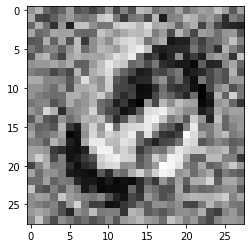

epoch= 1 	 time= 0.05477786858876546 min 	 lr= 0.0002 	 loss_d= 0.9305680349469185 	 loss_g= 1.2784087067842484
epoch= 2 	 time= 0.07396751244862874 min 	 lr= 0.0002 	 loss_d= 0.8705006021261216 	 loss_g= 1.4018494176864624
epoch= 3 	 time= 0.09274680217107137 min 	 lr= 0.0002 	 loss_d= 0.8245695340633392 	 loss_g= 1.5128518003225326
epoch= 4 	 time= 0.1115909457206726 min 	 lr= 0.0002 	 loss_d= 0.7745546501874924 	 loss_g= 1.6279465556144714
epoch= 5 	 time= 0.1305564085642497 min 	 lr= 0.0002 	 loss_d= 0.7402102220058441 	 loss_g= 1.7142705124616624


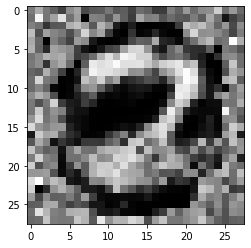

epoch= 6 	 time= 0.1514657457669576 min 	 lr= 0.0002 	 loss_d= 0.718082845211029 	 loss_g= 1.7974543160200118
epoch= 7 	 time= 0.1705289880434672 min 	 lr= 0.0002 	 loss_d= 0.7079407374560833 	 loss_g= 1.8449483609199524
epoch= 8 	 time= 0.18962666193644206 min 	 lr= 0.0002 	 loss_d= 0.6978975503146648 	 loss_g= 1.8979852080345154
epoch= 9 	 time= 0.2087635040283203 min 	 lr= 0.0002 	 loss_d= 0.7010449346899986 	 loss_g= 1.918608358502388
epoch= 10 	 time= 0.2278731902440389 min 	 lr= 0.0002 	 loss_d= 0.6705332206189633 	 loss_g= 1.9662166780233383


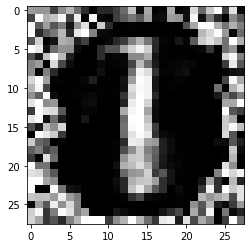

epoch= 11 	 time= 0.2489567001660665 min 	 lr= 0.0002 	 loss_d= 0.6638218311965466 	 loss_g= 1.9968654745817185
epoch= 12 	 time= 0.2679940462112427 min 	 lr= 0.0002 	 loss_d= 0.6511159744858742 	 loss_g= 2.0198432326316835
epoch= 13 	 time= 0.2871708671251933 min 	 lr= 0.0002 	 loss_d= 0.6511854086816311 	 loss_g= 2.0489322751760484
epoch= 14 	 time= 0.306177544593811 min 	 lr= 0.0002 	 loss_d= 0.6329393883049488 	 loss_g= 2.080729326605797
epoch= 15 	 time= 0.32522424856821697 min 	 lr= 0.0002 	 loss_d= 0.6460250620543957 	 loss_g= 2.0906161308288573


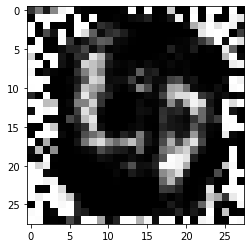

epoch= 16 	 time= 0.3461824337641398 min 	 lr= 0.0002 	 loss_d= 0.6394841632246971 	 loss_g= 2.128673751950264
epoch= 17 	 time= 0.36520022551218667 min 	 lr= 0.0002 	 loss_d= 0.6506831322610378 	 loss_g= 2.0949558210372925
epoch= 18 	 time= 0.38441222508748374 min 	 lr= 0.0002 	 loss_d= 0.6364356534183025 	 loss_g= 2.1222493070364
epoch= 19 	 time= 0.40356749296188354 min 	 lr= 0.0002 	 loss_d= 0.6375083173811436 	 loss_g= 2.155905623435974
epoch= 20 	 time= 0.4224778413772583 min 	 lr= 0.0002 	 loss_d= 0.6307875220477581 	 loss_g= 2.1717904764413833


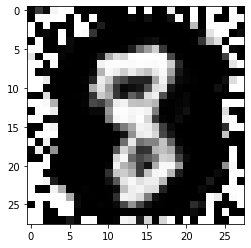

epoch= 21 	 time= 0.44323227008183796 min 	 lr= 0.0002 	 loss_d= 0.6456231135129928 	 loss_g= 2.1660407519340517
epoch= 22 	 time= 0.4623252749443054 min 	 lr= 0.0002 	 loss_d= 0.6408127896487713 	 loss_g= 2.178518874645233
epoch= 23 	 time= 0.4813634554545085 min 	 lr= 0.0002 	 loss_d= 0.6164329901337624 	 loss_g= 2.216785210967064
epoch= 24 	 time= 0.5007987896601359 min 	 lr= 0.0002 	 loss_d= 0.6337929749488831 	 loss_g= 2.2280065494775774
epoch= 25 	 time= 0.5201486388842265 min 	 lr= 0.0002 	 loss_d= 0.619560871720314 	 loss_g= 2.23972994863987


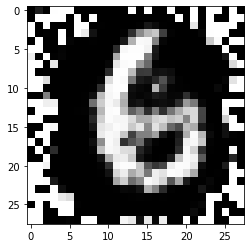

epoch= 26 	 time= 0.5411194245020549 min 	 lr= 0.0002 	 loss_d= 0.6340073144435883 	 loss_g= 2.2554630464315415
epoch= 27 	 time= 0.5604581475257874 min 	 lr= 0.0002 	 loss_d= 0.6031286177039147 	 loss_g= 2.294769010543823
epoch= 28 	 time= 0.5796715418497721 min 	 lr= 0.0002 	 loss_d= 0.6096241317689419 	 loss_g= 2.299722871184349
epoch= 29 	 time= 0.5987370769182842 min 	 lr= 0.0002 	 loss_d= 0.6126404350996018 	 loss_g= 2.303983797430992
epoch= 30 	 time= 0.6178277889887492 min 	 lr= 0.0002 	 loss_d= 0.5935806809365749 	 loss_g= 2.337745008468628


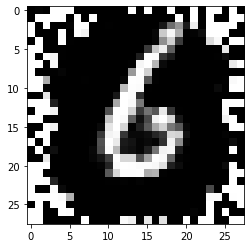

epoch= 31 	 time= 0.6391781648000081 min 	 lr= 0.0002 	 loss_d= 0.6200281602144241 	 loss_g= 2.327619999051094
epoch= 32 	 time= 0.6583124279975892 min 	 lr= 0.0002 	 loss_d= 0.5887693780660629 	 loss_g= 2.3817252761125562
epoch= 33 	 time= 0.677509093284607 min 	 lr= 0.0002 	 loss_d= 0.5840871402621269 	 loss_g= 2.3949041920900345
epoch= 34 	 time= 0.696529217561086 min 	 lr= 0.0002 	 loss_d= 0.5848619554936886 	 loss_g= 2.4321829295158386
epoch= 35 	 time= 0.7156703472137451 min 	 lr= 0.0002 	 loss_d= 0.6089168457686901 	 loss_g= 2.4007137447595595


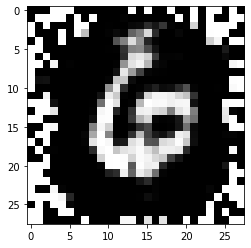

epoch= 36 	 time= 0.7365267992019653 min 	 lr= 0.0002 	 loss_d= 0.5989102725684643 	 loss_g= 2.3877546286582945
epoch= 37 	 time= 0.7555867552757263 min 	 lr= 0.0002 	 loss_d= 0.5995367129147052 	 loss_g= 2.4262288880348204
epoch= 38 	 time= 0.7747008244196574 min 	 lr= 0.0002 	 loss_d= 0.5908481845259667 	 loss_g= 2.441708193421364
epoch= 39 	 time= 0.7937266667683919 min 	 lr= 0.0002 	 loss_d= 0.5870565706491471 	 loss_g= 2.469106280207634
epoch= 40 	 time= 0.8129703879356385 min 	 lr= 0.0002 	 loss_d= 0.5823214234411717 	 loss_g= 2.4482531571388244


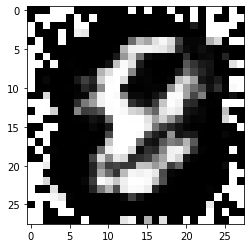

epoch= 41 	 time= 0.834057895342509 min 	 lr= 0.0002 	 loss_d= 0.5727440223097802 	 loss_g= 2.5007291901111603
epoch= 42 	 time= 0.8534605741500855 min 	 lr= 0.0002 	 loss_d= 0.576396492421627 	 loss_g= 2.4709855675697328
epoch= 43 	 time= 0.8726192196210225 min 	 lr= 0.0002 	 loss_d= 0.5910802780091763 	 loss_g= 2.501267120838165
epoch= 44 	 time= 0.8918203592300415 min 	 lr= 0.0002 	 loss_d= 0.5551182848215103 	 loss_g= 2.5391102612018583
epoch= 45 	 time= 0.910983411471049 min 	 lr= 0.0002 	 loss_d= 0.5706948611140251 	 loss_g= 2.539969789981842


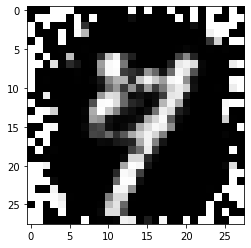

epoch= 46 	 time= 0.9320364276568095 min 	 lr= 0.0002 	 loss_d= 0.5654441990703344 	 loss_g= 2.5565446996688843
epoch= 47 	 time= 0.951284380753835 min 	 lr= 0.0002 	 loss_d= 0.5683184778690338 	 loss_g= 2.5629829597473144
epoch= 48 	 time= 0.9707014640172322 min 	 lr= 0.0002 	 loss_d= 0.5807427188754082 	 loss_g= 2.5622077798843383
epoch= 49 	 time= 0.9898236632347107 min 	 lr= 0.0002 	 loss_d= 0.5727871438860893 	 loss_g= 2.561962877511978


In [8]:
# Training loop
net_g = generator()
net_g = net_g.to(device)
print(net_g)
utils.display_num_param(net_g) 
net_d = discriminator()
net_d = net_d.to(device)
print(net_d)
utils.display_num_param(net_d) 

# Optimizer
init_lr = 0.0002
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=init_lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=init_lr, betas=(0.5, 0.999))

nb_batch = 200 # GPU # Nb of mini-batches per epoch
#nb_batch = 20 # CPU # Nb of mini-batches per epoch
b = 64  # Batch size

p_one = torch.ones(b, 1).to(device)
p_zero = torch.zeros(b, 1).to(device)

start=time.time()
for epoch in range(50):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        idx = torch.LongTensor(b).random_(0,60000)
        x_real = train_data[idx,:,:].view(b,-1).to(device) # [b, n**2]
        z = torch.rand(b, dz).to(device) # Uniform distribution # [b, dz]
        
        # update d
        optimizer_d.zero_grad()
        x_fake = net_g(z) # [b, 1, n, n]
        p_fake = net_d(x_fake) # [b, 1]
        p_real = net_d(x_real.view(-1,n,n).unsqueeze(1)) # [b, 1]
        loss_real = nn.BCELoss()(p_real, p_one)
        loss_fake = nn.BCELoss()(p_fake, p_zero)
        loss = loss_real + loss_fake
        loss_d = loss.detach().item()
        loss.backward()
        optimizer_d.step()
        
        # update g
        optimizer_g.zero_grad()
        x_fake = net_g(z) # [b, 1, n, n]
        p_fake = net_d(x_fake) # [b, 1]
        loss_fake = nn.BCELoss()(p_fake, p_one)
        loss = loss_fake
        loss_g = loss.detach().item()
        loss.backward()
        optimizer_g.step()

        # COMPUTE STATS
        running_loss_d += loss_d
        running_loss_g += loss_g
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss_d = running_loss_d/ num_batches
    total_loss_g = running_loss_g/ num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss_d=', total_loss_d ,'\t loss_g=', total_loss_g )

    if not epoch%5:
        plt.imshow(x_fake.view(b,n,n).detach().cpu()[0,:,:], cmap='gray'); plt.show() 
    

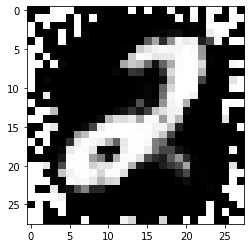

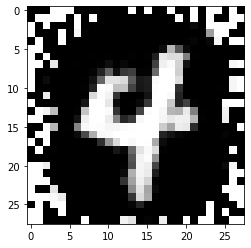

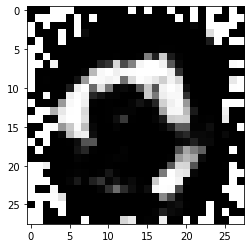

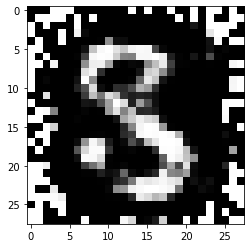

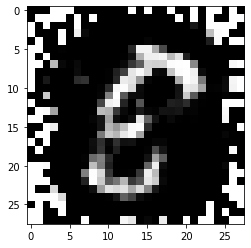

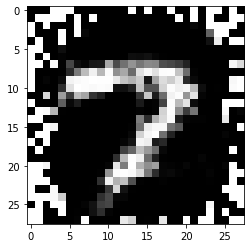

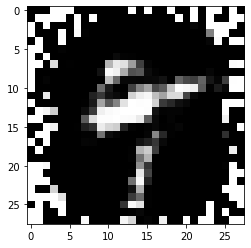

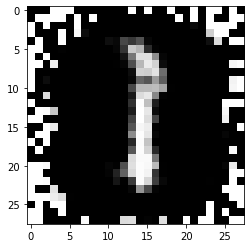

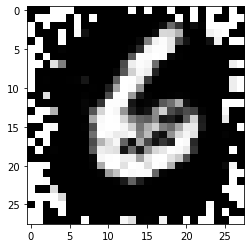

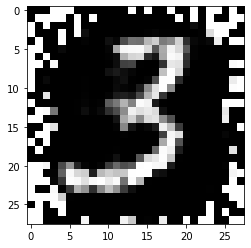

In [9]:
# Generate a few images
b = 10
z = torch.rand(b, dz) # Uniform distribution 
z = z.to(device)
x_new = net_g(z).view(b,n,n).detach().cpu()
for k in range(b):
    plt.imshow(x_new[k,:,:], cmap='gray'); plt.show() 
  